# Predicting Player Login Patterns: Forecasting Hourly Login Counts on a Minecraft Research Server

# Introduction

When designing an online game server, it’s useful to figure out when players are most likely to log in. This helps the programmers with planning maintenance, managing server load, and understanding the general player activity patterns. For many players, logins tend to follow clear time-of-day or day-of-week patterns, so it’s reasonable to ask whether we can predict player activity ahead of time.

In this project, we will focus on the question:

**Can we predict how many unique players will log into the server during a given hour of the day?**

To explore the question, we will use an anonymous play session log from a Minecraft research server hosted by Dr. Wood's group at the University of British Columbia. Each row in the dataset represents one gameplay session, and it includes when a player logged in and when they logged out. The session log file (`sessions.csv`) contains 1,535 rows and the following variables:

- **hashedEmail** — anonymized player ID  
- **start_time** — session start timestamp (YYYY-MM-DD HH:MM:SS)  
- **end_time** — session end timestamp (YYYY-MM-DD HH:MM:SS)  
- **original_start_time** — raw start timestamp before adjustment  
- **original_end_time** — raw end timestamp before adjustment  

Using these timestamps, we transform the data into an hourly-level dataset. For each session start time, we extract several useful variables:

- **date** — calendar date of the login  
- **hour** — hour of day (0–23)  
- **weekday** — day of week (Mon–Sun)  
- **is_weekend** — TRUE/FALSE indicator for weekends  
- **n_logins** — number of unique players starting a session during each hour (our target variable)

This wrangled dataset is what we will use for our exploratory analysis and for building a model to predict hourly login counts.



## Methods

This section describes the steps used to prepare the dataset, explore basic login patterns, and build predictive models to forecast hourly login counts.

### 1. Loading libraries and importing the data

We begin by loading the packages required for data wrangling, working with timestamps, visualization, and modeling. We then import the play-session log (`sessions.csv`), with every row representing a single gameplay session on the Minecraft server.


In [1]:
set.seed(18)
library(tidyverse)
library(lubridate)
library(tidymodels)
options(repr.matrix.max.rows = 6)

sessions <- read_csv("data/sessions.csv")
sessions


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


### 2. Cleaning and preparing the timestamp variables

The session timestamps are stored as character strings. To work with them properly, we need to convert the timestamp columns into datetime objects and remove rows with missing values to ensure that each session has a valid start time.

In [2]:
sessions_clean <- sessions |>
  mutate(start_time = dmy_hm(start_time), 
         end_time   = dmy_hm(end_time)) |>
  drop_na(start_time)
sessions_clean

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12


### 3. Creating hourly features and aggregating login counts

To prepare the data for analysis, we will convert the session-level column into an hourly column.  
For each session's start time, we will extract:

- the date
- the hour of the day
- the weekday
- whether or not the day is a weekend

We then count the number of **unique players** who started a session in each hour.  
The resulting variable `n_logins` represents the number of players logging in during that hour and can be used as the target for prediction.

After creating these features, we can see that the dataset now contains one row per hour instead of one row per session.


In [9]:
login_counts <- sessions_clean |>
  mutate(date = as_date(start_time),
    hour = hour(start_time),
    weekday = wday(start_time, label = TRUE, abbr = TRUE),
    is_weekend = weekday %in% c("Sat", "Sun")) |>
  group_by(date, hour, weekday, is_weekend) |>
  summarise(n_logins = n_distinct(hashedEmail), .groups = "drop")

login_counts


date,hour,weekday,is_weekend,n_logins
<date>,<int>,<ord>,<lgl>,<int>
2024-04-06,9,Sat,TRUE,1
2024-04-06,20,Sat,TRUE,1
2024-04-06,22,Sat,TRUE,1
⋮,⋮,⋮,⋮,⋮
2024-09-21,23,Sat,TRUE,1
2024-09-24,6,Tue,FALSE,1
2024-09-26,6,Thu,FALSE,1


### 4. Splitting the data into training and testing sets

Since the data form a time series of hourly login counts, we will split the dataset in time order. The first 75% of the rows are used for the training set, while the last 25% are kept as the test set. This allows us to evaluate how well the model can predict future login behaviour.


In [11]:
login_counts <- login_counts |>
  arrange(date, hour)

data_split <- initial_time_split(login_counts, prop = 0.75) #initial_time_split keeps it in chronological order
train_data <- training(data_split)
test_data <- testing(data_split)

head(train_data)
head(test_data)

date,hour,weekday,is_weekend,n_logins
<date>,<int>,<ord>,<lgl>,<int>
2024-04-06,9,Sat,TRUE,1
2024-04-06,20,Sat,TRUE,1
2024-04-06,22,Sat,TRUE,1
2024-04-07,0,Sun,TRUE,1
2024-04-07,2,Sun,TRUE,1
2024-04-07,5,Sun,TRUE,2


date,hour,weekday,is_weekend,n_logins
<date>,<int>,<ord>,<lgl>,<int>
2024-07-27,0,Sat,TRUE,2
2024-07-27,2,Sat,TRUE,1
2024-07-27,4,Sat,TRUE,1
2024-07-27,10,Sat,TRUE,1
2024-07-27,15,Sat,TRUE,1
2024-07-27,17,Sat,TRUE,1


### 5. Exploratory visualization

To see when players tend to log in, we use the training data to plot the average number of logins for each hour of the day. This gives a simple view of daily patterns before fitting any models.

Figure 1 shows the mean hourly login count across all days in the training set.


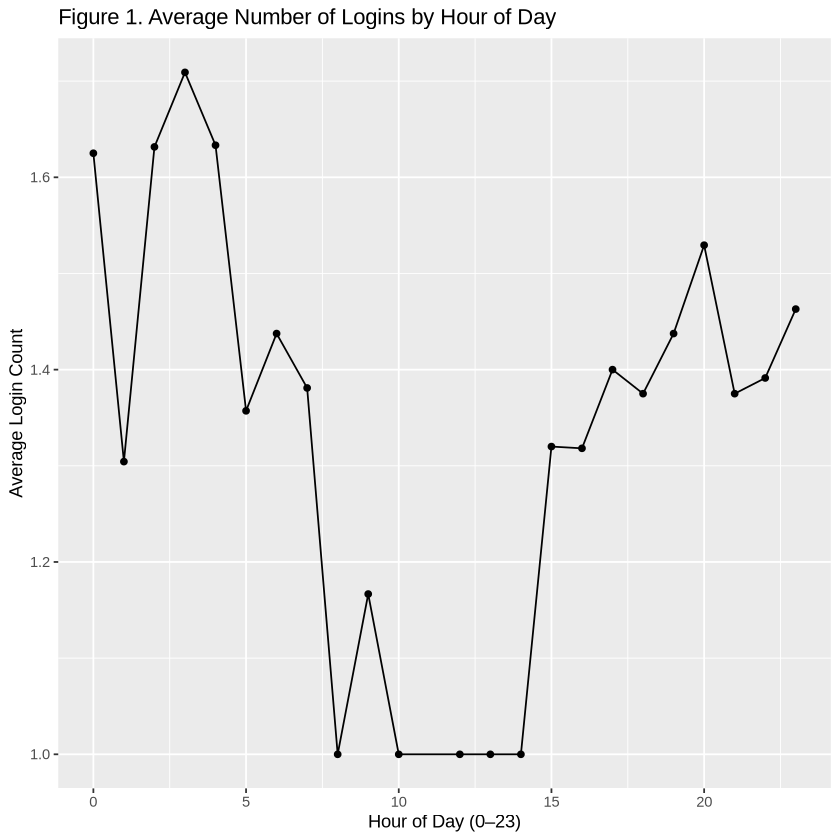

In [12]:
eda_plot <- train_data |>
  group_by(hour) |>
  summarise(mean_logins = mean(n_logins)) |>
  ggplot(aes(x = hour, y = mean_logins)) +
  geom_line() +
  geom_point() +
  labs(title = "Figure 1. Average Number of Logins by Hour of Day",
    x = "Hour of Day (0–23)",
    y = "Average Login Count")

eda_plot

### 6. Building the prediction model

To forecast hourly login counts, we fit a k-nearest neighbours (KNN) regression model.  
The model uses three time-based features:

- hour of day  
- weekday  
- weekend indicator  

These features describe when each hour occurs and capture the main temporal patterns in the data. We train the model on the first 75% of the observations (the training set) and then use it to predict the login counts in the remaining 25% (the test set).


In [6]:
login_recipe <- recipe(n_logins ~ hour + weekday + is_weekend, data = train_data) |>
  step_dummy(all_nominal_predictors())

knn_spec <- nearest_neighbor(
  mode = "regression",
  neighbors = 5
) |>
  set_engine("kknn")

knn_workflow <- workflow() |>
  add_recipe(login_recipe) |>
  add_model(knn_spec)

knn_fit <- knn_workflow |>
  fit(data = train_data)

knn_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

knn_rmse <- knn_predictions |>
  rmse(truth = n_logins, estimate = .pred)

knn_rmse


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.851593


### 7. Model evaluation

To evaluate the kNN regression model, we first compute the RMSE on the test set. To visualize the overall model performance in a simple way, we compare the average actual login count to the average predicted login count in the test data. Figure 2 shows both values side by side.


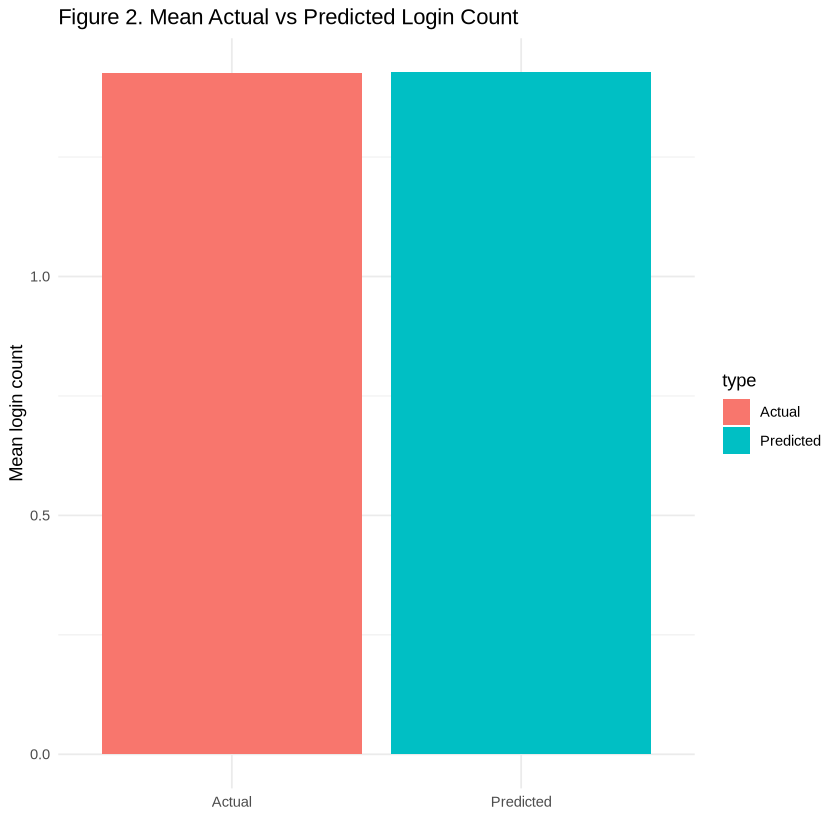

In [7]:
mean_values <- tibble(
  type = c("Actual", "Predicted"),
  value = c(mean(knn_predictions$n_logins), mean(knn_predictions$.pred))
)

ggplot(mean_values, aes(x = type, y = value, fill = type)) +
  geom_col() +
  labs(
    title = "Figure 2. Mean Actual vs Predicted Login Count",
    x = "",
    y = "Mean login count"
  ) +
  theme_minimal()

### Summary of model evaluation

The kNN model produces predicted login counts that are similar to the overall average of the actual data in the test set. While the model captures basic patterns, the RMSE and the comparison in Figure 2 show that its predictions are approximate and not exact, which is expected given the small number of features used.
